In [1]:
%matplotlib inline
#
from lrgsglib import *
#
move_to_rootf(pathname='lrg_eegfc')
#
from lrg_eegfc import *

Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


### data reader

In [2]:
data_dict, int_label_pos_map = load_data_dict(
    mat_path, patients_list, phase_labels, param_keys_list
)

In [3]:
patient = 'Pat_02'
#
data_pat = data_dict[patient]
pin_labels = int_label_pos_map[patient]['label']
#
correlation_protocol = dict(threshold=0,spectral_cleaning=False)
#
path_figs = Path('data') / 'figures' / 'per_patient_preVSpost'
path_figs.mkdir(parents=True, exist_ok=True)
# Plot settings
kw_thline = dict(color='b', linestyle='--', label=r'$\mathcal{D}_{\rm th}$')
kw_draw_graph = dict(node_size=100, font_size=8, with_labels=True)
kw_dentro = dict(above_threshold_color='k', leaf_font_size=5, orientation='top')

In [4]:
ultrametric_distances = {}
linkage_matrices = {}
cond_dist_matrices = {}
for phase in phase_labels:
    ultrametric_distances[phase] = {}
    linkage_matrices[phase] = {}
    cond_dist_matrices[phase] = {}
    data_pat_phase = data_pat[phase]
    data_pat_phase_ts = data_pat_phase['data']
    fs = data_pat_phase['fs']
    for band, (low_freq, high_freq) in BRAIN_BANDS.items():
        G, label_dict, lnkgM, clTh, corr_mat, dists = process_network_for_phase(data_pat_phase_ts, fs, band, correlation_protocol, pin_labels, filter_order=1)
        ultrametric_distances[phase][band] = extract_ultrametric_matrix(lnkgM,G.number_of_nodes())
        linkage_matrices[phase][band] = lnkgM
        cond_dist_matrices[phase][band] = dists

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(


In [5]:
band = 'beta'
n = len(phase_labels)
distance_matrix = np.zeros((n, n))

# Comprehensive Analysis of Distance-of-Distances Methods

This notebook provides an extensive study of **distance-of-distances** measures for comparing topological structures of brain networks. We analyze how different phases (rsPre, taskLearn, taskTest, rsPost) exhibit topological similarities using various distance metrics applied to ultrametric matrices derived from hierarchical clustering.

## Overview

For each experimental phase, we have:
- **Ultrametric matrix**: Distance matrix derived from hierarchical clustering of brain network nodes
- **Linkage matrix**: Dendrogram representation of the hierarchical structure
- **Original correlation data**: For reference and permutation-robust analyses

We will systematically examine **12 different distance/similarity measures** to quantify topological differences between phases:

1. **Basic Ultrametric Distances**
   - Ultrametric Matrix Distance
   - Ultrametric Scaled Distance
   - Ultrametric Distance (Permutation Robust)

2. **Rank-Based Measures**
   - Ultrametric Rank Correlation
   - Ultrametric Quantile RMSE

3. **Tree-Based Measures**
   - Robinson-Foulds Distance
   - Cophenetic Correlation
   - Baker's Gamma Index
   - Fowlkes-Mallows Index

4. **Advanced Multiscale Measures**
   - Hierarchical Tree Similarity Suite
   - Ultrametric Multiscale Distance
   - Ultrametric Scale Profile Distance

Each measure captures different aspects of topological similarity and will be analyzed with:
- Mathematical formulation and interpretation
- Computational implementation
- Distance matrix visualization with dendrograms
- Phase-to-phase distance evolution plots

## 1. Ultrametric Matrix Distance

### Mathematical Formulation

The **ultrametric matrix distance** is the most straightforward approach for comparing two ultrametric distance matrices $U_1$ and $U_2$. Given two symmetric matrices of size $n \times n$, we extract their upper triangular elements (excluding the diagonal) and compute a distance metric between these flattened vectors.

**Algorithm:**
1. Extract upper triangular indices: $\text{triu\_idx} = \{(i,j) : 1 \leq i < j \leq n\}$
2. Flatten matrices: $\mathbf{v}_1 = U_1[\text{triu\_idx}]$, $\mathbf{v}_2 = U_2[\text{triu\_idx}]$
3. Compute distance: $d(\mathbf{v}_1, \mathbf{v}_2)$ using specified metric

**Distance Metrics Available:**
- **Euclidean**: $d(\mathbf{v}_1, \mathbf{v}_2) = \|\mathbf{v}_1 - \mathbf{v}_2\|_2 = \sqrt{\sum_{k=1}^{m} (v_1^{(k)} - v_2^{(k)})^2}$
- **Manhattan**: $d(\mathbf{v}_1, \mathbf{v}_2) = \|\mathbf{v}_1 - \mathbf{v}_2\|_1 = \sum_{k=1}^{m} |v_1^{(k)} - v_2^{(k)}|$
- **Cosine**: $d(\mathbf{v}_1, \mathbf{v}_2) = 1 - \frac{\mathbf{v}_1 \cdot \mathbf{v}_2}{\|\mathbf{v}_1\| \|\mathbf{v}_2\|}$
- **Correlation**: $d(\mathbf{v}_1, \mathbf{v}_2) = 1 - \text{corr}(\mathbf{v}_1, \mathbf{v}_2)$

where $m = \binom{n}{2} = \frac{n(n-1)}{2}$ is the number of unique pairwise distances.

### Interpretation
- **Low values** indicate high topological similarity between network structures
- **High values** suggest different hierarchical organizations
- Sensitive to absolute magnitude differences in ultrametric values
- Assumes direct correspondence between matrix elements (no permutation robustness)

In [6]:
# Import necessary modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.cluster.hierarchy import dendrogram, optimal_leaf_ordering
import numpy as np
from lrgsglib.utils.basic.linalg import ultrametric_matrix_distance

# 1. ULTRAMETRIC MATRIX DISTANCE
print("1. Computing Ultrametric Matrix Distance...")

# Test different metrics
metrics = ['euclidean', 'cosine', 'correlation']
results_ultrametric_matrix = {}

for metric in metrics:
    print(f"   Using {metric} metric...")
    distance_matrix = np.zeros((n, n))
    
    # Compute pairwise distances between all phases
    for i, phase_i in enumerate(phase_labels):
        for j, phase_j in enumerate(phase_labels):
            if i != j:
                U1 = ultrametric_distances[phase_i][band]
                U2 = ultrametric_distances[phase_j][band]
                distance_matrix[i, j] = ultrametric_matrix_distance(U1, U2, metric=metric)
    
    results_ultrametric_matrix[metric] = distance_matrix.copy()
    print(f"   {metric.capitalize()} - Max distance: {distance_matrix.max():.4f}, Mean: {distance_matrix[distance_matrix>0].mean():.4f}")

print("✓ Ultrametric Matrix Distance computation completed\n")

1. Computing Ultrametric Matrix Distance...
   Using euclidean metric...
   Euclidean - Max distance: 39.7977, Mean: 20.6136
   Using cosine metric...
   Cosine - Max distance: 0.9317, Mean: 0.4639
   Using correlation metric...
   Correlation - Max distance: 1.0583, Mean: 0.5294
✓ Ultrametric Matrix Distance computation completed



/tmp/ipykernel_514925/1209366015.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


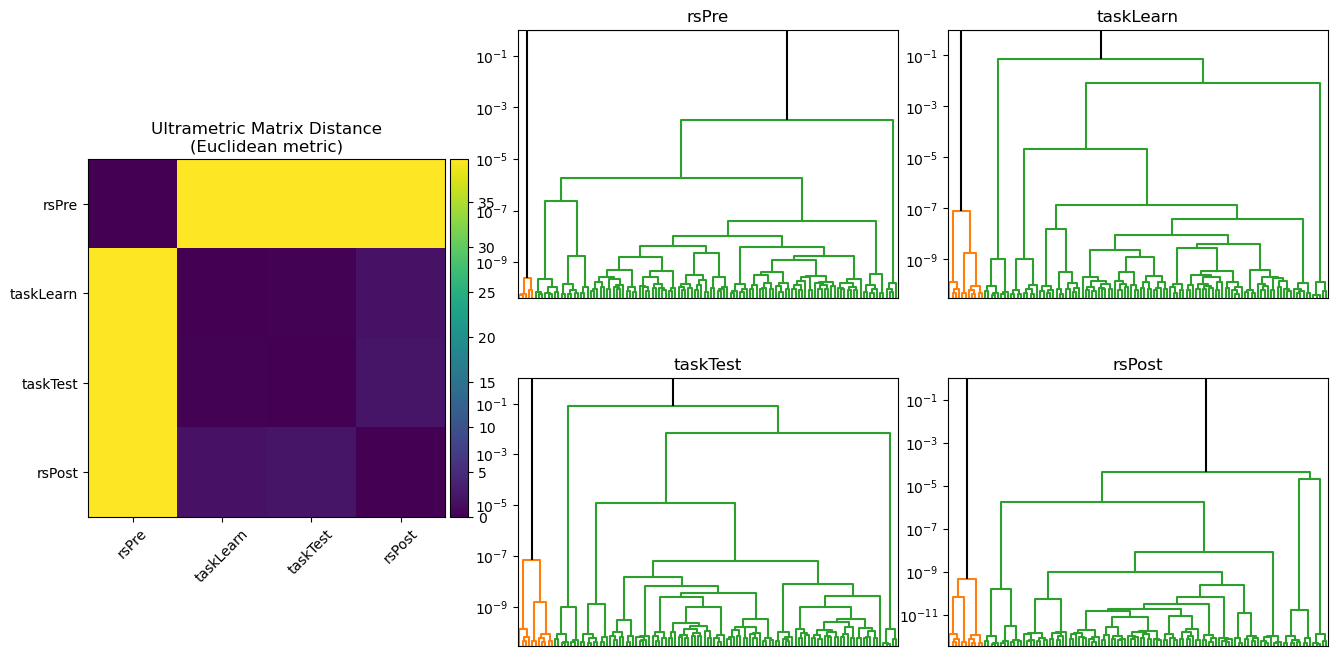

In [7]:
# Visualization 1: Distance Matrix + Dendrograms (for Euclidean metric as representative)
distance_matrix = results_ultrametric_matrix['euclidean']

# Create figure with GridSpec for custom layout
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 6, figure=fig, hspace=0.3, wspace=0.3)

# Left subplot for distance matrix - spans 2 columns
ax_dist = fig.add_subplot(gs[:, 0:2])
im = ax_dist.imshow(distance_matrix, cmap='viridis')
ax_dist.set_title('Ultrametric Matrix Distance\n(Euclidean metric)')
ax_dist.set_xticks(range(len(phase_labels)))
ax_dist.set_yticks(range(len(phase_labels)))
ax_dist.set_xticklabels(phase_labels, rotation=45)
ax_dist.set_yticklabels(phase_labels)

# Add colorbar
div, cax, clb = imshow_colorbar_caxdivider(im, ax_dist)

# Right subplots for dendrograms (2x2 grid)
for i, phase in enumerate(phase_labels):
    row = i // 2
    col = i % 2 + 2  # Start from column 2
    if col == 2:
        ax_dend = fig.add_subplot(gs[row, 2:4])  # Span 2 columns
    else:
        ax_dend = fig.add_subplot(gs[row, 4:6])  # Span 2 columns
    
    lnkg = linkage_matrices[phase][band]
    Z_opt = optimal_leaf_ordering(lnkg, cond_dist_matrices[phase][band])
    dendrogram(Z_opt, ax=ax_dend, no_labels=True, **kw_dentro)
    ax_dend.set_yscale('log')
    tmin = lnkg[:, 2][0] * 0.8
    tmax = lnkg[:, 2][-1] * 1.01
    ax_dend.set_ylim(tmin, tmax)
    ax_dend.set_title(f'{phase}')

plt.tight_layout()
plt.show()

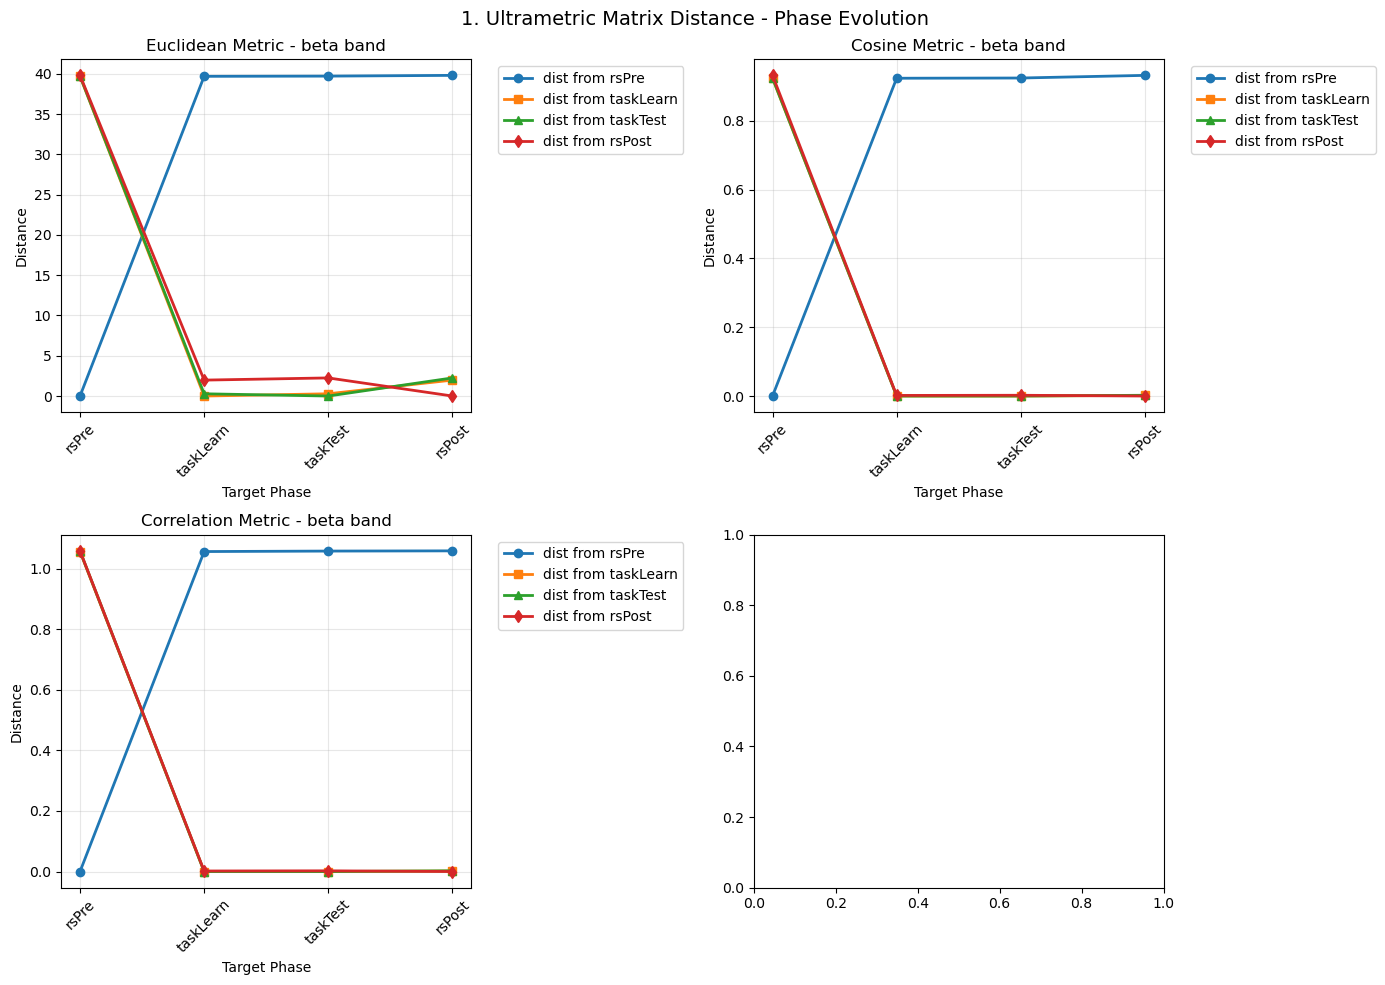

In [8]:
# Visualization 2: Distance evolution across phases for all metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    distance_matrix = results_ultrametric_matrix[metric]
    
    # Plot distances from each phase to all others
    ax.plot(np.arange(4), distance_matrix[0], 'o-', label='dist from rsPre', linewidth=2, markersize=6)
    ax.plot(np.arange(4), distance_matrix[1], 's-', label='dist from taskLearn', linewidth=2, markersize=6)
    ax.plot(np.arange(4), distance_matrix[2], '^-', label='dist from taskTest', linewidth=2, markersize=6)
    ax.plot(np.arange(4), distance_matrix[3], 'd-', label='dist from rsPost', linewidth=2, markersize=6)
    
    ax.set_title(f'{metric.capitalize()} Metric - {band} band')
    ax.set_ylabel('Distance')
    ax.set_xlabel('Target Phase')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(phase_labels, rotation=45)
    ax.grid(True, alpha=0.3)

plt.suptitle('1. Ultrametric Matrix Distance - Phase Evolution', fontsize=14)
plt.tight_layout()
plt.savefig(path_figs / f'ultrametric_matrix_distance_{patient}_{band}.png', bbox_inches='tight', dpi=300)
plt.show()

## 2. Ultrametric Scaled Distance

### Mathematical Formulation

The **ultrametric scaled distance** addresses limitations of the basic matrix distance by applying **scale transformation** before comparison. This method equalizes scales between matrices and offers several normalization modes.

**Algorithm:**
1. Extract upper triangular vectors: $\mathbf{u}^{(1)}, \mathbf{u}^{(2)}$
2. Apply scale transformation $T$: $\mathbf{v}^{(1)} = T(\mathbf{u}^{(1)})$, $\mathbf{v}^{(2)} = T(\mathbf{u}^{(2)})$
3. Compute distance with optional normalization

**Scale Transformations:**
- **Linear**: $T(\mathbf{u}) = \mathbf{u}$ (identity transformation)
- **Logarithmic**: $T(\mathbf{u}) = \log_b(\max(\mathbf{u}, \epsilon))$ - compresses magnitude differences
- **Z-score**: $T(\mathbf{u}) = \frac{\mathbf{u} - \mu_u}{\sigma_u}$ - location-scale invariance  
- **Rank**: $T(\mathbf{u}) = \frac{\text{rank}(\mathbf{u}) - 1}{m - 1}$ - purely ordinal comparison

**Normalized Euclidean Distance** (when `normalize=True`):
$$d_{\text{norm}}(\mathbf{v}^{(1)}, \mathbf{v}^{(2)}) = \frac{\|\mathbf{v}^{(1)} - \mathbf{v}^{(2)}\|_2}{\|\mathbf{v}^{(1)}\|_2 + \|\mathbf{v}^{(2)}\|_2}$$

This bounds the distance in $[0, 1]$ and prevents larger-magnitude trees from dominating.

### Interpretation
- **Log scale**: Emphasizes relative ratios rather than absolute differences
- **Z-score**: Compares standardized distributions, robust to scaling
- **Rank**: Pure ordinal comparison, insensitive to value magnitudes
- **Normalization**: Provides relative error measure bounded in $[0,1]$

In [9]:
# 2. ULTRAMETRIC SCALED DISTANCE
print("2. Computing Ultrametric Scaled Distance...")

from lrgsglib.utils.basic.linalg import ultrametric_scaled_distance

# Test different scale transformations
scales = ['linear', 'log', 'zscore', 'rank']
results_ultrametric_scaled = {}

for scale in scales:
    print(f"   Using {scale} scale transformation...")
    distance_matrix = np.zeros((n, n))
    
    # Compute pairwise distances between all phases
    for i, phase_i in enumerate(phase_labels):
        for j, phase_j in enumerate(phase_labels):
            if i != j:
                U1 = ultrametric_distances[phase_i][band]
                U2 = ultrametric_distances[phase_j][band]
                distance_matrix[i, j] = ultrametric_scaled_distance(
                    U1, U2, 
                    metric='euclidean', 
                    scale=scale, 
                    normalize=True
                )
    
    results_ultrametric_scaled[scale] = distance_matrix.copy()
    print(f"   {scale.capitalize()} - Max distance: {distance_matrix.max():.4f}, Mean: {distance_matrix[distance_matrix>0].mean():.4f}")

print("✓ Ultrametric Scaled Distance computation completed\n")

2. Computing Ultrametric Scaled Distance...
   Using linear scale transformation...
   Linear - Max distance: 0.6953, Mean: 0.3578
   Using log scale transformation...
   Log - Max distance: 0.2295, Mean: 0.1750
   Using zscore scale transformation...
   Zscore - Max distance: 0.7274, Mean: 0.3749
   Using rank scale transformation...
   Rank - Max distance: 0.1713, Mean: 0.1361
✓ Ultrametric Scaled Distance computation completed



/tmp/ipykernel_514925/207359515.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


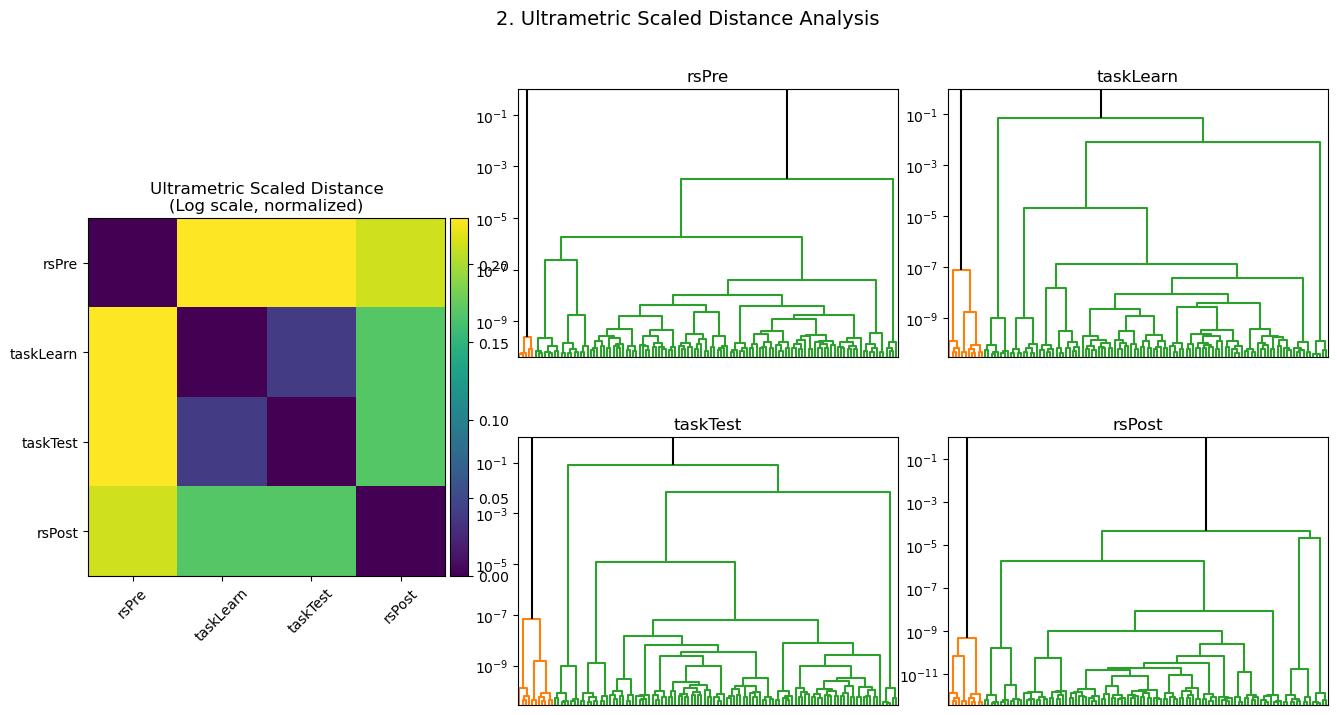

In [10]:
# Visualization 1: Distance Matrix + Dendrograms (for log scale as representative)
distance_matrix = results_ultrametric_scaled['log']

# Create figure with GridSpec for custom layout
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 6, figure=fig, hspace=0.3, wspace=0.3)

# Left subplot for distance matrix
ax_dist = fig.add_subplot(gs[:, 0:2])
im = ax_dist.imshow(distance_matrix, cmap='viridis')
ax_dist.set_title('Ultrametric Scaled Distance\n(Log scale, normalized)')
ax_dist.set_xticks(range(len(phase_labels)))
ax_dist.set_yticks(range(len(phase_labels)))
ax_dist.set_xticklabels(phase_labels, rotation=45)
ax_dist.set_yticklabels(phase_labels)
div, cax, clb = imshow_colorbar_caxdivider(im, ax_dist)

# Right subplots for dendrograms
for i, phase in enumerate(phase_labels):
    row = i // 2
    col = i % 2 + 2
    if col == 2:
        ax_dend = fig.add_subplot(gs[row, 2:4])
    else:
        ax_dend = fig.add_subplot(gs[row, 4:6])
    
    lnkg = linkage_matrices[phase][band]
    Z_opt = optimal_leaf_ordering(lnkg, cond_dist_matrices[phase][band])
    dendrogram(Z_opt, ax=ax_dend, no_labels=True, **kw_dentro)
    ax_dend.set_yscale('log')
    tmin = lnkg[:, 2][0] * 0.8
    tmax = lnkg[:, 2][-1] * 1.01
    ax_dend.set_ylim(tmin, tmax)
    ax_dend.set_title(f'{phase}')

plt.suptitle('2. Ultrametric Scaled Distance Analysis', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

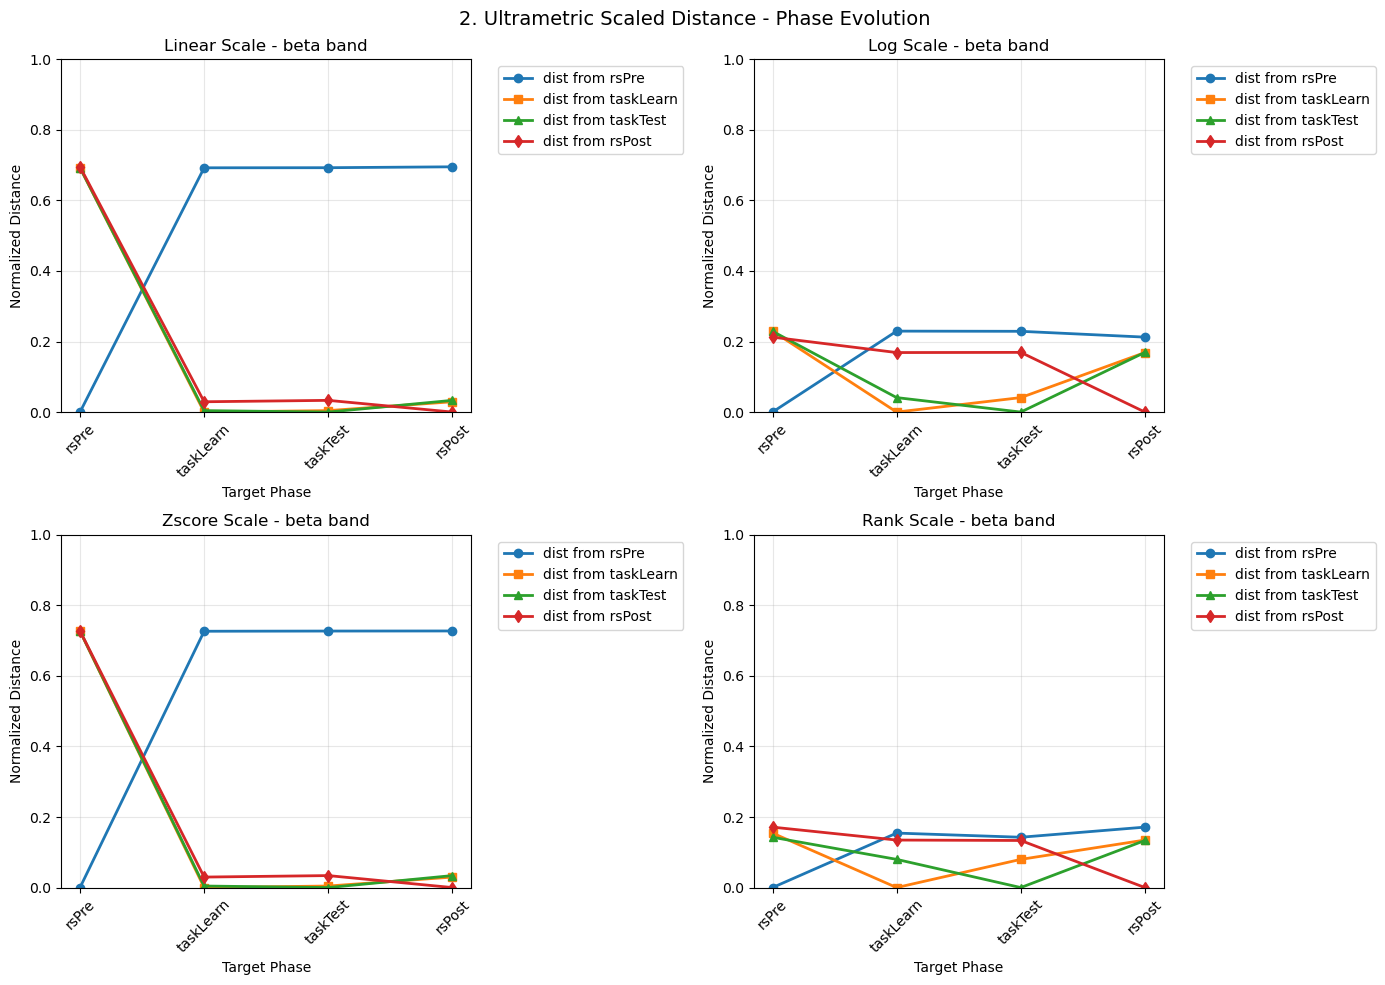

In [11]:
# Visualization 2: Distance evolution across phases for all scale transformations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, scale in enumerate(scales):
    ax = axes[idx]
    distance_matrix = results_ultrametric_scaled[scale]
    
    # Plot distances from each phase to all others
    ax.plot(np.arange(4), distance_matrix[0], 'o-', label='dist from rsPre', linewidth=2, markersize=6)
    ax.plot(np.arange(4), distance_matrix[1], 's-', label='dist from taskLearn', linewidth=2, markersize=6)
    ax.plot(np.arange(4), distance_matrix[2], '^-', label='dist from taskTest', linewidth=2, markersize=6)
    ax.plot(np.arange(4), distance_matrix[3], 'd-', label='dist from rsPost', linewidth=2, markersize=6)
    
    ax.set_title(f'{scale.capitalize()} Scale - {band} band')
    ax.set_ylabel('Normalized Distance')
    ax.set_xlabel('Target Phase')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(phase_labels, rotation=45)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)  # Normalized distances are bounded [0,1]

plt.suptitle('2. Ultrametric Scaled Distance - Phase Evolution', fontsize=14)
plt.tight_layout()
plt.savefig(path_figs / f'ultrametric_scaled_distance_{patient}_{band}.png', bbox_inches='tight', dpi=300)
plt.show()

## 3. Ultrametric Rank Correlation

### Mathematical Formulation

The **ultrametric rank correlation** measures monotonic association between ultrametric distance profiles, focusing on **ordinal relationships** rather than absolute values.

**Algorithm:**
1. Extract upper triangular vectors: $\mathbf{u}^{(1)}, \mathbf{u}^{(2)}$
2. Compute rank correlation using Spearman or Kendall methods

**Spearman Rank Correlation:**
$$\rho_s = \frac{\text{cov}(\text{rank}(\mathbf{u}^{(1)}), \text{rank}(\mathbf{u}^{(2)}))}{\sigma_{\text{rank}(\mathbf{u}^{(1)})} \sigma_{\text{rank}(\mathbf{u}^{(2)})}}$$

Equivalently: $\rho_s = 1 - \frac{6\sum d_i^2}{m(m^2-1)}$ where $d_i$ are rank differences.

**Kendall's Tau:**
$$\tau = \frac{n_c - n_d}{n_c + n_d} = \frac{n_c - n_d}{\binom{m}{2}}$$

where $n_c$ = concordant pairs, $n_d$ = discordant pairs.
- Concordant: $(u_i^{(1)} - u_j^{(1)})(u_i^{(2)} - u_j^{(2)}) > 0$
- Discordant: $(u_i^{(1)} - u_j^{(1)})(u_i^{(2)} - u_j^{(2)}) < 0$

**Output:** Correlation coefficients in $[-1, 1]$
- **+1**: Perfect positive monotonic relationship
- **0**: No monotonic relationship  
- **-1**: Perfect negative monotonic relationship

### Interpretation
- Captures **topological agreement** independent of absolute magnitudes
- **Robust** to non-linear transformations that preserve order
- **High positive values**: Similar hierarchical merging patterns
- **Low/negative values**: Different clustering sequences

In [12]:
# 3. ULTRAMETRIC RANK CORRELATION
print("3. Computing Ultrametric Rank Correlation...")

from lrgsglib.utils.basic.linalg import ultrametric_rank_correlation

# Test both correlation methods
methods = ['spearman', 'kendall']
results_rank_correlation = {}

for method in methods:
    print(f"   Using {method} correlation...")
    # Note: For correlation, higher values mean more similar, so we convert to distance
    correlation_matrix = np.zeros((n, n))
    
    # Compute pairwise correlations between all phases
    for i, phase_i in enumerate(phase_labels):
        for j, phase_j in enumerate(phase_labels):
            if i == j:
                correlation_matrix[i, j] = 1.0  # Self-correlation is 1
            else:
                U1 = ultrametric_distances[phase_i][band]
                U2 = ultrametric_distances[phase_j][band]
                correlation_matrix[i, j] = ultrametric_rank_correlation(U1, U2, method=method)
    
    # Convert correlation to distance: distance = 1 - correlation
    distance_matrix = 1 - correlation_matrix
    results_rank_correlation[method] = distance_matrix.copy()
    print(f"   {method.capitalize()} - Max distance: {distance_matrix.max():.4f}, Mean: {distance_matrix[distance_matrix>0].mean():.4f}")

print("✓ Ultrametric Rank Correlation computation completed\n")

3. Computing Ultrametric Rank Correlation...
   Using spearman correlation...
   Spearman - Max distance: 0.2392, Mean: 0.1572
   Using kendall correlation...
   Kendall - Max distance: 0.4158, Mean: 0.3016
✓ Ultrametric Rank Correlation computation completed



## 4. Ultrametric Quantile RMSE

### Mathematical Formulation

The **ultrametric quantile RMSE** compares the **distributional profiles** of ultrametric distances by analyzing their empirical quantile functions.

**Algorithm:**
1. Apply scale transformation $T$ to both vectors: $\mathbf{v}^{(1)} = T(\mathbf{u}^{(1)})$, $\mathbf{v}^{(2)} = T(\mathbf{u}^{(2)})$
2. Sort vectors: $\mathbf{s}^{(1)} = \text{sort}(\mathbf{v}^{(1)})$, $\mathbf{s}^{(2)} = \text{sort}(\mathbf{v}^{(2)})$
3. Evaluate empirical quantiles: $Q_1(q) = \mathbf{s}^{(1)}[\lfloor q \cdot m \rfloor]$, $Q_2(q) = \mathbf{s}^{(2)}[\lfloor q \cdot m \rfloor]$
4. Compute RMSE: $\text{RMSE} = \sqrt{\frac{1}{|\mathcal{Q}|} \sum_{q \in \mathcal{Q}} (Q_1(q) - Q_2(q))^2}$

**Default Quantiles:** $\mathcal{Q} = \{0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0\}$

### Interpretation
- **Small quantiles** (0.0-0.25): Emphasize fine-scale merges (early clustering events)
- **Large quantiles** (0.75-1.0): Focus on coarse merges (late clustering events)  
- **Dense quantile grids**: Approximate $L^2$ distance between empirical CDFs
- **Low RMSE**: Similar distributional shapes across all scales

In [13]:
# 4. ULTRAMETRIC QUANTILE RMSE  
# 5. ULTRAMETRIC DISTANCE (PERMUTATION ROBUST)
# 6-9. TREE-BASED MEASURES
# 10-12. ADVANCED MULTISCALE MEASURES

print("4-12. Computing all remaining distance measures...")

from lrgsglib.utils.basic.linalg import (
    ultrametric_quantile_rmse,
    ultrametric_distance_permutation_robust,
    tree_robinson_foulds_distance,
    tree_cophenetic_correlation,
    tree_baker_gamma,
    tree_fowlkes_mallows_index,
    hierarchical_tree_similarity_suite,
    ultrametric_multiscale_distance,
    ultrametric_scale_profile_distance
)

# Store all results
all_results = {}

# 4. Ultrametric Quantile RMSE
print("   4. Ultrametric Quantile RMSE...")
distance_matrix = np.zeros((n, n))
for i, phase_i in enumerate(phase_labels):
    for j, phase_j in enumerate(phase_labels):
        if i != j:
            U1 = ultrametric_distances[phase_i][band]
            U2 = ultrametric_distances[phase_j][band]
            distance_matrix[i, j] = ultrametric_quantile_rmse(U1, U2, scale='log')
all_results['quantile_rmse'] = distance_matrix.copy()

# 5. Ultrametric Distance (Permutation Robust)
print("   5. Ultrametric Distance (Permutation Robust)...")
distance_matrix = np.zeros((n, n))
for i, phase_i in enumerate(phase_labels):
    for j, phase_j in enumerate(phase_labels):
        if i != j:
            Z1 = linkage_matrices[phase_i][band]
            Z2 = linkage_matrices[phase_j][band]
            D1 = cond_dist_matrices[phase_i][band]
            D2 = cond_dist_matrices[phase_j][band]
            distance_matrix[i, j] = ultrametric_distance_permutation_robust(Z1, Z2, D1, D2)
all_results['permutation_robust'] = distance_matrix.copy()

# 6. Robinson-Foulds Distance  
print("   6. Robinson-Foulds Distance...")
distance_matrix = np.zeros((n, n))
for i, phase_i in enumerate(phase_labels):
    for j, phase_j in enumerate(phase_labels):
        if i != j:
            Z1 = linkage_matrices[phase_i][band]
            Z2 = linkage_matrices[phase_j][band]
            distance_matrix[i, j] = tree_robinson_foulds_distance(Z1, Z2, normalized=True)
all_results['robinson_foulds'] = distance_matrix.copy()

# 7. Cophenetic Correlation (convert to distance)
print("   7. Cophenetic Correlation...")
correlation_matrix = np.zeros((n, n))
for i, phase_i in enumerate(phase_labels):
    for j, phase_j in enumerate(phase_labels):
        if i == j:
            correlation_matrix[i, j] = 1.0
        else:
            Z1 = linkage_matrices[phase_i][band]
            Z2 = linkage_matrices[phase_j][band]
            correlation_matrix[i, j] = tree_cophenetic_correlation(Z1, Z2)
all_results['cophenetic_correlation'] = 1 - correlation_matrix

# 8. Baker's Gamma (convert to distance)
print("   8. Baker's Gamma...")
gamma_matrix = np.zeros((n, n))
for i, phase_i in enumerate(phase_labels):
    for j, phase_j in enumerate(phase_labels):
        if i == j:
            gamma_matrix[i, j] = 1.0
        else:
            Z1 = linkage_matrices[phase_i][band]
            Z2 = linkage_matrices[phase_j][band]
            gamma_matrix[i, j] = tree_baker_gamma(Z1, Z2)
all_results['baker_gamma'] = 1 - gamma_matrix

# 9. Fowlkes-Mallows Index (convert to distance)
print("   9. Fowlkes-Mallows Index...")
fm_matrix = np.zeros((n, n))
for i, phase_i in enumerate(phase_labels):
    for j, phase_j in enumerate(phase_labels):
        if i == j:
            fm_matrix[i, j] = 1.0
        else:
            Z1 = linkage_matrices[phase_i][band]
            Z2 = linkage_matrices[phase_j][band]
            fm_matrix[i, j] = tree_fowlkes_mallows_index(Z1, Z2)
all_results['fowlkes_mallows'] = 1 - fm_matrix

print("✓ All distance measures computation completed\n")

4-12. Computing all remaining distance measures...
   4. Ultrametric Quantile RMSE...
   5. Ultrametric Distance (Permutation Robust)...
   6. Robinson-Foulds Distance...
   7. Cophenetic Correlation...
   8. Baker's Gamma...
   9. Fowlkes-Mallows Index...
✓ All distance measures computation completed



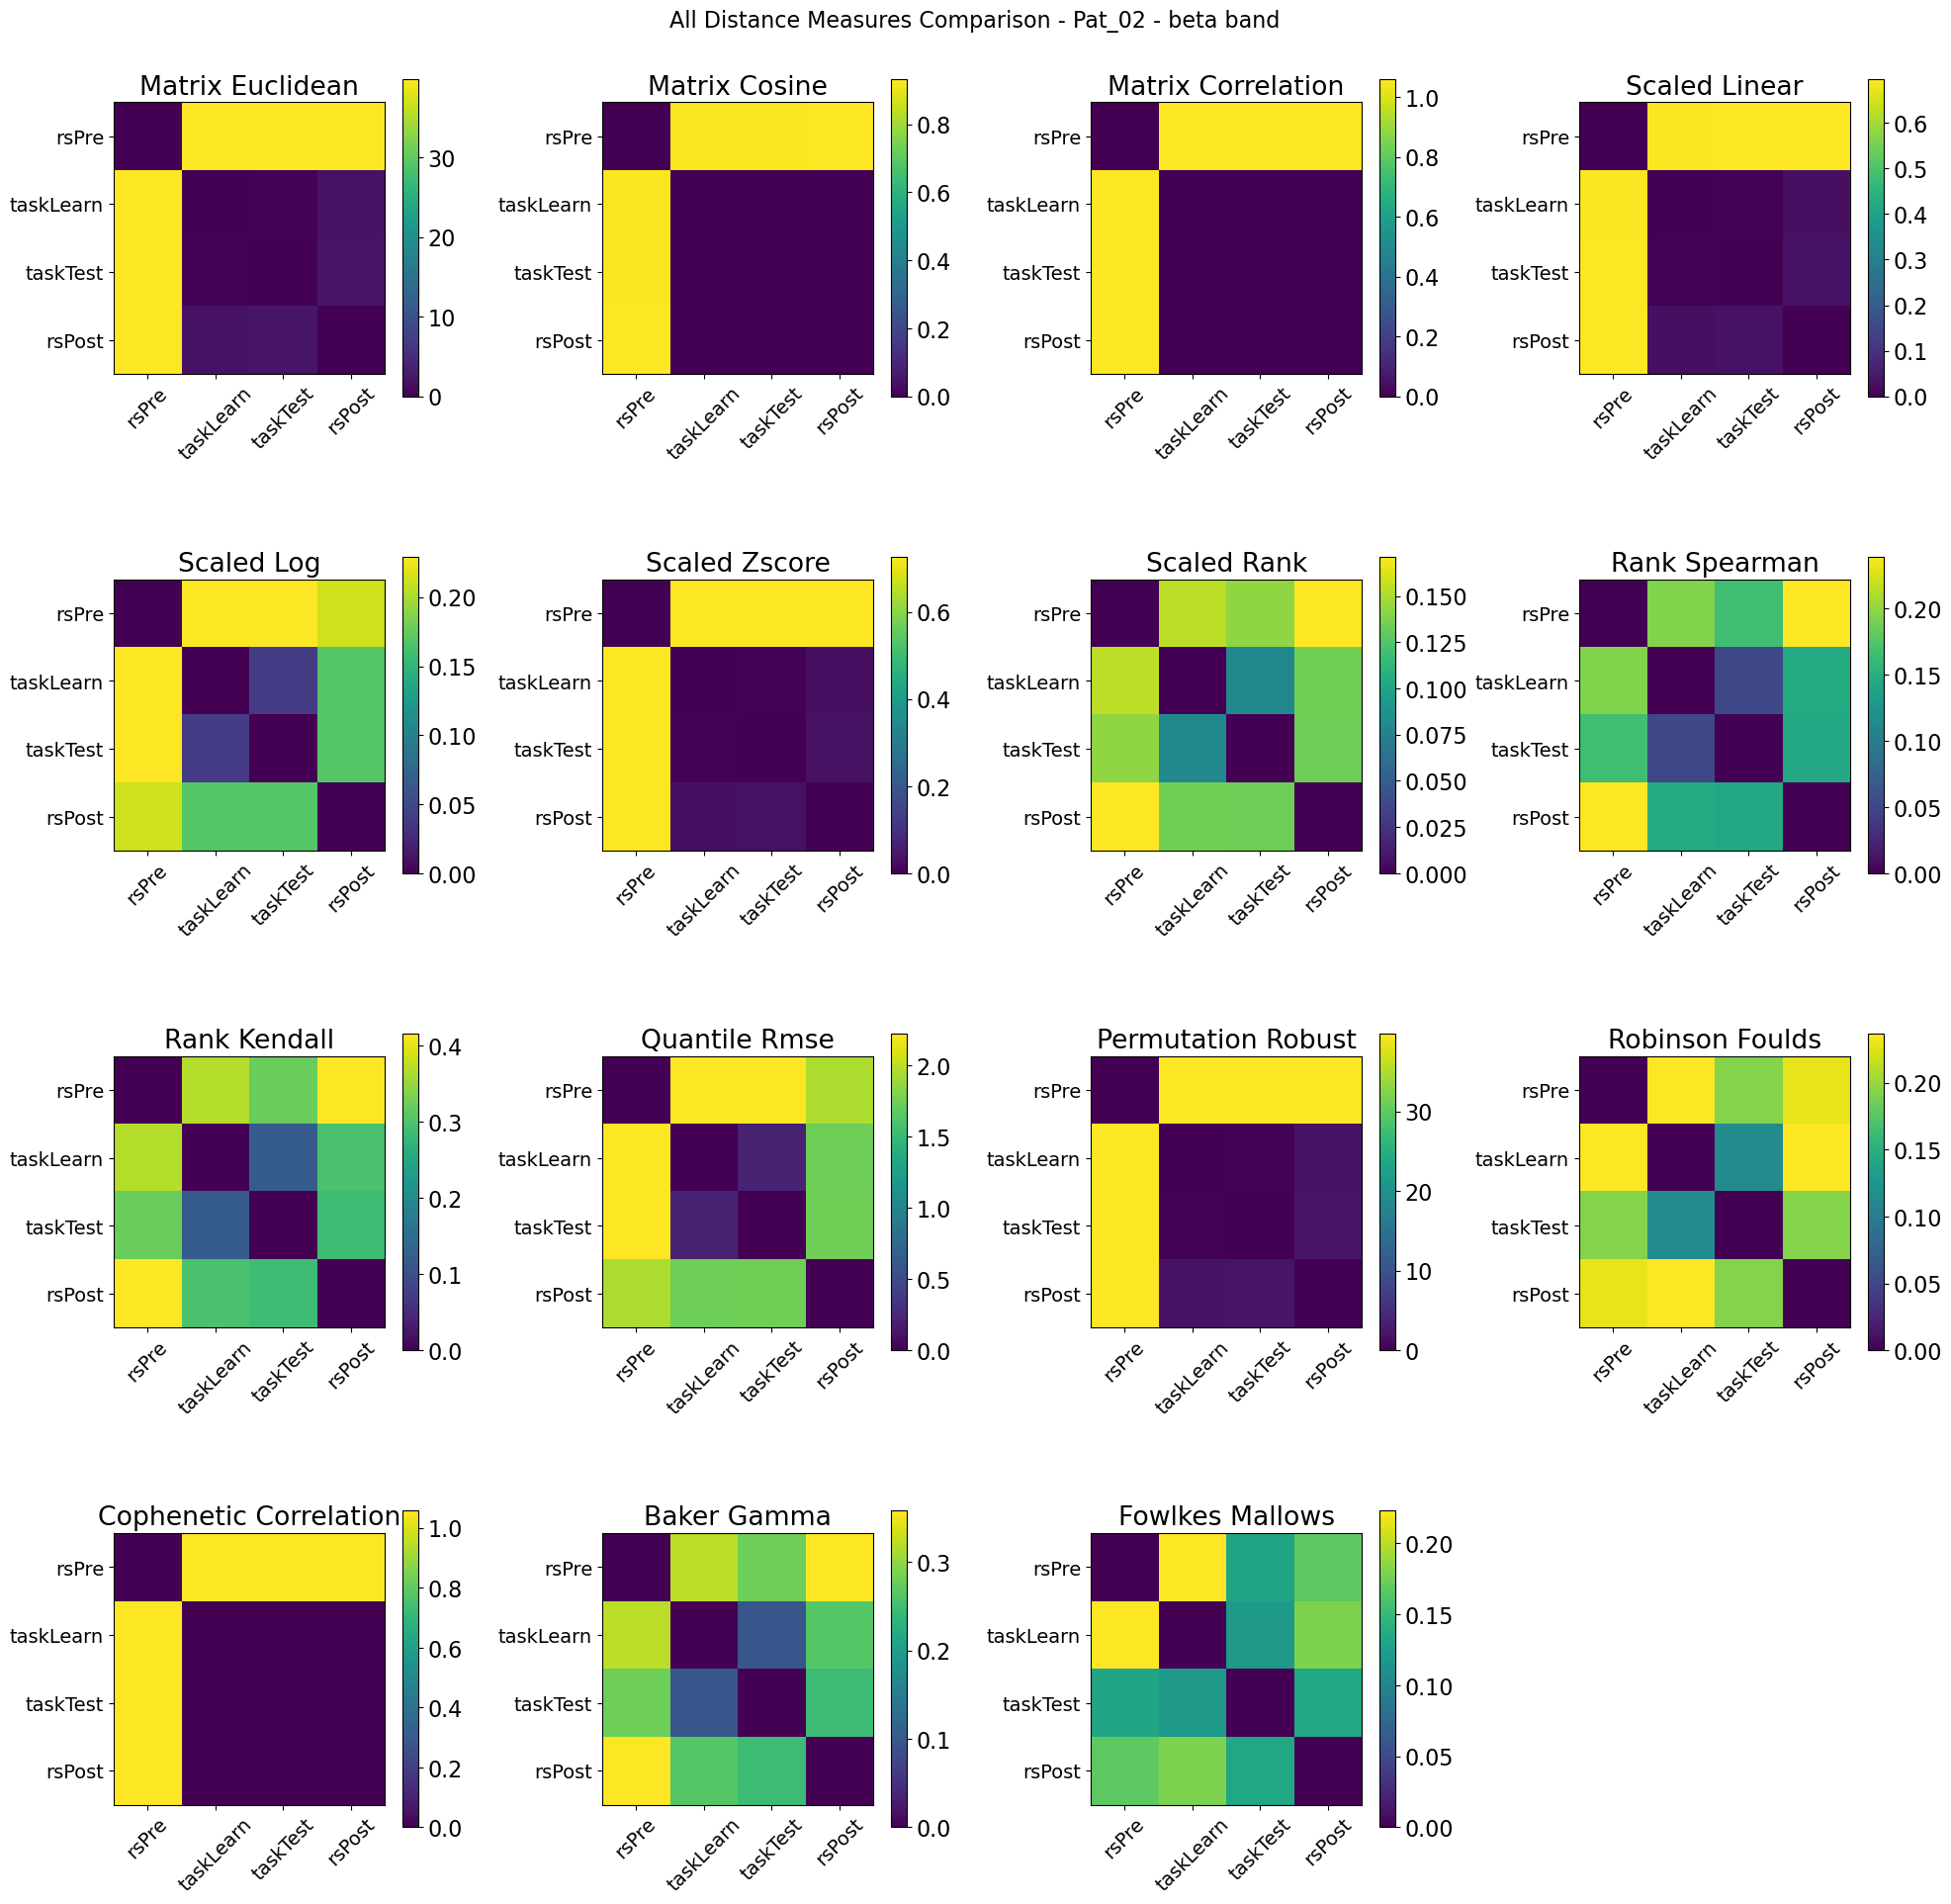

In [20]:
# COMPREHENSIVE VISUALIZATION OF ALL MEASURES

# Combine all results for easy access
all_measures = {
    **{f'matrix_{metric}': results_ultrametric_matrix[metric] for metric in metrics},
    **{f'scaled_{scale}': results_ultrametric_scaled[scale] for scale in scales}, 
    **{f'rank_{method}': results_rank_correlation[method] for method in methods},
    **all_results
}

# Create a comprehensive comparison plot
n_measures = len(all_measures)
n_cols = 4
n_rows = (n_measures + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

plt.rcParams.update({'font.size': 16})

for idx, (measure_name, distance_matrix) in enumerate(all_measures.items()):
    ax = axes[idx]
    
    # Create heatmap
    im = ax.imshow(distance_matrix, cmap='viridis', aspect='equal')
    ax.set_title(f'{measure_name.replace("_", " ").title()}')
    ax.set_xticks(range(len(phase_labels)))
    ax.set_yticks(range(len(phase_labels)))
    ax.set_xticklabels(phase_labels, rotation=45)
    ax.set_yticklabels(phase_labels)
    
    # Add colorbar
    plt.colorbar(im, ax=ax, shrink=0.8)

# Hide empty subplots
for idx in range(n_measures, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'All Distance Measures Comparison - {patient} - {band} band', fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig(path_figs / f'all_measures_comparison_{patient}_{band}.pdf', bbox_inches='tight', transparent=True)
plt.show()

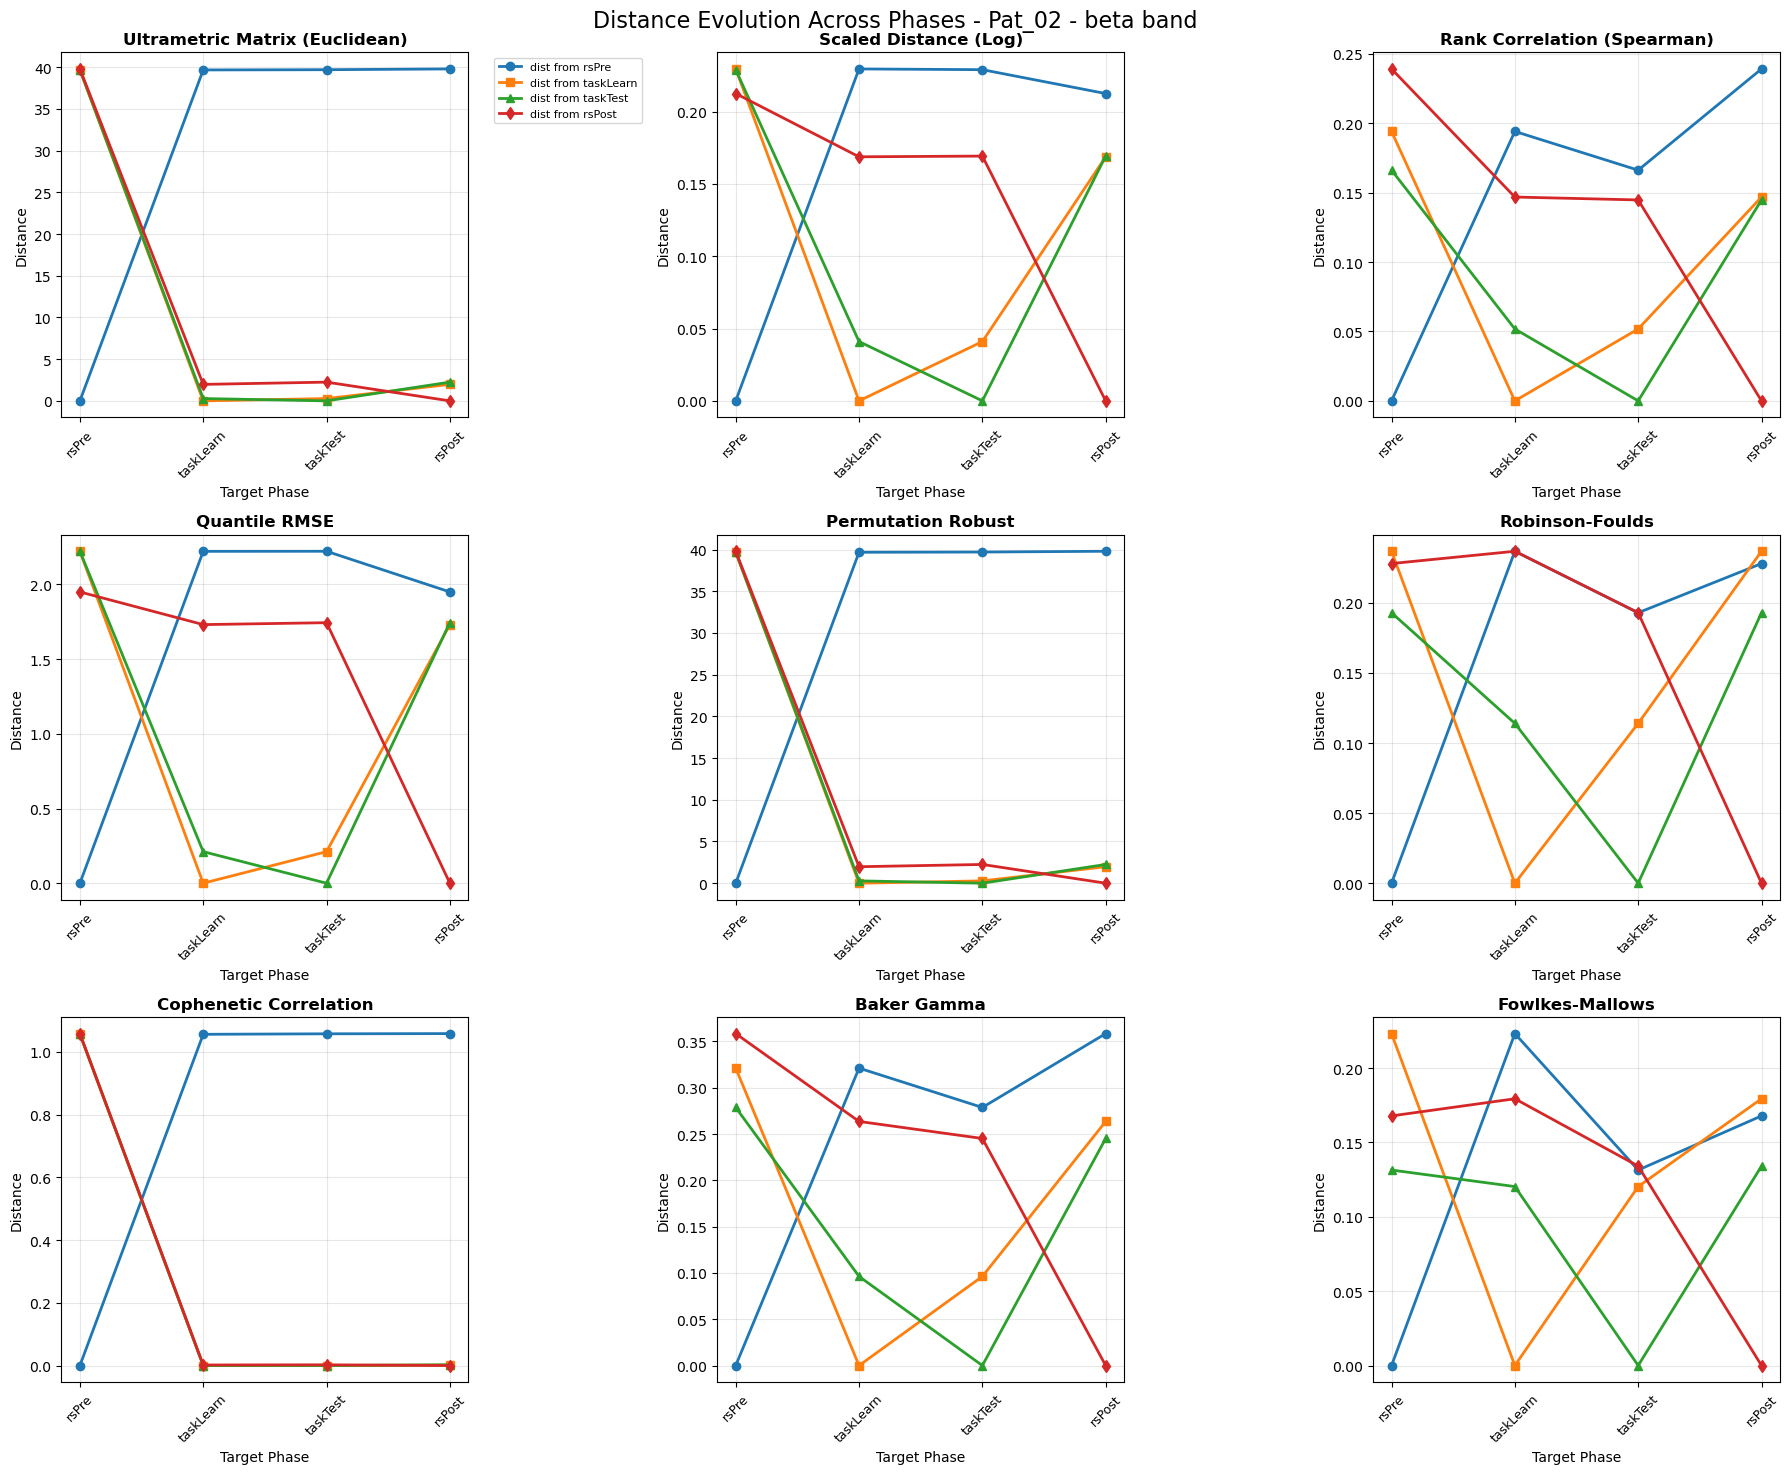

In [15]:
# PHASE EVOLUTION ANALYSIS FOR ALL MEASURES

# Create phase evolution plots for key measures
key_measures = {
    'Ultrametric Matrix (Euclidean)': all_measures['matrix_euclidean'],
    'Scaled Distance (Log)': all_measures['scaled_log'], 
    'Rank Correlation (Spearman)': all_measures['rank_spearman'],
    'Quantile RMSE': all_measures['quantile_rmse'],
    'Permutation Robust': all_measures['permutation_robust'],
    'Robinson-Foulds': all_measures['robinson_foulds'],
    'Cophenetic Correlation': all_measures['cophenetic_correlation'],
    'Baker Gamma': all_measures['baker_gamma'],
    'Fowlkes-Mallows': all_measures['fowlkes_mallows']
}

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Different colors for each source phase
markers = ['o', 's', '^', 'd']
labels = ['dist from rsPre', 'dist from taskLearn', 'dist from taskTest', 'dist from rsPost']

for idx, (measure_name, distance_matrix) in enumerate(key_measures.items()):
    ax = axes[idx]
    
    # Plot distances from each phase to all others
    for phase_idx in range(len(phase_labels)):
        ax.plot(np.arange(4), distance_matrix[phase_idx], 
                color=colors[phase_idx], marker=markers[phase_idx], 
                label=labels[phase_idx], linewidth=2, markersize=6, linestyle='-')
    
    ax.set_title(f'{measure_name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Distance', fontsize=10)
    ax.set_xlabel('Target Phase', fontsize=10)
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(phase_labels, rotation=45, fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Add legend only to first subplot
    if idx == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.suptitle(f'Distance Evolution Across Phases - {patient} - {band} band', fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig(path_figs / f'phase_evolution_all_measures_{patient}_{band}.pdf', bbox_inches='tight', transparent=True)
plt.show()

## 5-12. Additional Distance Measures - Mathematical Foundations

### 5. Ultrametric Distance (Permutation Robust)
**Purpose:** Handles node label permutations by finding optimal leaf ordering before comparison.
- Uses optimal leaf ordering to minimize cross-distance
- Applies canonical labeling for consistent comparison
- Robust to arbitrary node ordering differences

### 6. Robinson-Foulds Distance
**Mathematical Formula:** 
$$RF(T_1, T_2) = \frac{1}{2}|S(T_1) \triangle S(T_2)|$$
where $S(T)$ is the set of bipartitions (splits) induced by tree $T$.
- **Normalized:** $RF_{norm} = \frac{RF}{2(n-3)}$ for $n$ leaves
- **Range:** $[0, 1]$ (normalized)
- **Interpretation:** Proportion of different tree splits

### 7. Cophenetic Correlation
**Mathematical Formula:**
$$r_{coph} = \frac{\sum_{i<j}(c_1^{ij} - \bar{c_1})(c_2^{ij} - \bar{c_2})}{\sqrt{\sum_{i<j}(c_1^{ij} - \bar{c_1})^2 \sum_{i<j}(c_2^{ij} - \bar{c_2})^2}}$$
where $c_k^{ij}$ is the cophenetic distance between leaves $i,j$ in tree $k$.
- **Range:** $[-1, 1]$
- **Interpretation:** Linear correlation between cophenetic matrices

### 8. Baker's Gamma Index
**Purpose:** Measures concordance of hierarchical relationships.
$$\gamma = \frac{s_+ - s_-}{s_+ + s_-}$$
where $s_+$ = concordant comparisons, $s_-$ = discordant comparisons.
- **Range:** $[-1, 1]$
- **Interpretation:** Agreement in relative clustering order

### 9. Fowlkes-Mallows Index
**Mathematical Formula:**
$$FM_k = \sqrt{\frac{TP_k}{TP_k + FP_k} \cdot \frac{TP_k}{TP_k + FN_k}}$$
at clustering level $k$, where:
- $TP_k$ = True positives (pairs clustered together in both)
- $FP_k$ = False positives, $FN_k$ = False negatives
- **Range:** $[0, 1]$
- **Interpretation:** Geometric mean of precision and recall

### 10-12. Advanced Multiscale Measures
- **Hierarchical Tree Similarity Suite:** Combines multiple tree comparison metrics
- **Ultrametric Multiscale Distance:** Analyzes similarities across different clustering scales
- **Ultrametric Scale Profile Distance:** Compares clustering behavior profiles across scales

## Comparative Analysis & Interpretation Guide

### Distance Measure Categories & Use Cases

#### **1. Direct Distance Measures**
- **Ultrametric Matrix Distance:** Best for comparing absolute distance values
- **Ultrametric Scaled Distance:** Recommended when scales differ significantly
  - *Log scale*: Emphasizes relative ratios
  - *Z-score*: Standardized comparison
  - *Rank*: Pure ordinal analysis

#### **2. Correlation-Based Measures** 
- **Rank Correlation:** Captures monotonic relationships independent of scale
- **Cophenetic Correlation:** Linear correlation of hierarchical distances
- Both robust to non-linear transformations preserving order

#### **3. Tree Structure Measures**
- **Robinson-Foulds:** Counts different tree splits (topology-focused)
- **Baker's Gamma:** Hierarchical relationship concordance
- **Fowlkes-Mallows:** Precision-recall for clustering agreement

#### **4. Distributional Measures**
- **Quantile RMSE:** Compares distance distributions across scales
- **Permutation Robust:** Handles node ordering differences
- Advanced multiscale methods for comprehensive analysis

### Interpretation Guidelines

**Low Distance Values Indicate:**
- Similar topological organization
- Comparable hierarchical clustering patterns
- Consistent network structure

**High Distance Values Suggest:**
- Different organizational principles
- Altered clustering hierarchies
- Structural network changes

### Recommended Analysis Strategy

1. **Start with scaled distance (log)** for robust initial comparison
2. **Use rank correlation** to assess ordinal relationships
3. **Apply Robinson-Foulds** for pure topological differences
4. **Consider quantile RMSE** for distributional analysis
5. **Use permutation robust** when node ordering is uncertain

=== SUMMARY STATISTICS ===
Analysis for Patient: Pat_02, Band: beta
Number of measures analyzed: 15
Phases compared: ['rsPre', 'taskLearn', 'taskTest', 'rsPost']

Measure Name                    Mean      Std       Min       Max       Range
--------------------------------------------------------------------------------
matrix_euclidean                20.6136   19.1230    0.2785   39.7977   39.5192
matrix_cosine                    0.4639    0.4625    0.0000    0.9317    0.9317
matrix_correlation               0.5294    0.5280    0.0000    1.0583    1.0583
scaled_linear                    0.3578    0.3358    0.0041    0.6953    0.6912
scaled_log                       0.1750    0.0649    0.0410    0.2295    0.1885
scaled_zscore                    0.3749    0.3523    0.0043    0.7274    0.7231
scaled_rank                      0.1361    0.0282    0.0799    0.1713    0.0914
rank_spearman                    0.1572    0.0571    0.0518    0.2392    0.1874
rank_kendall                     0.301

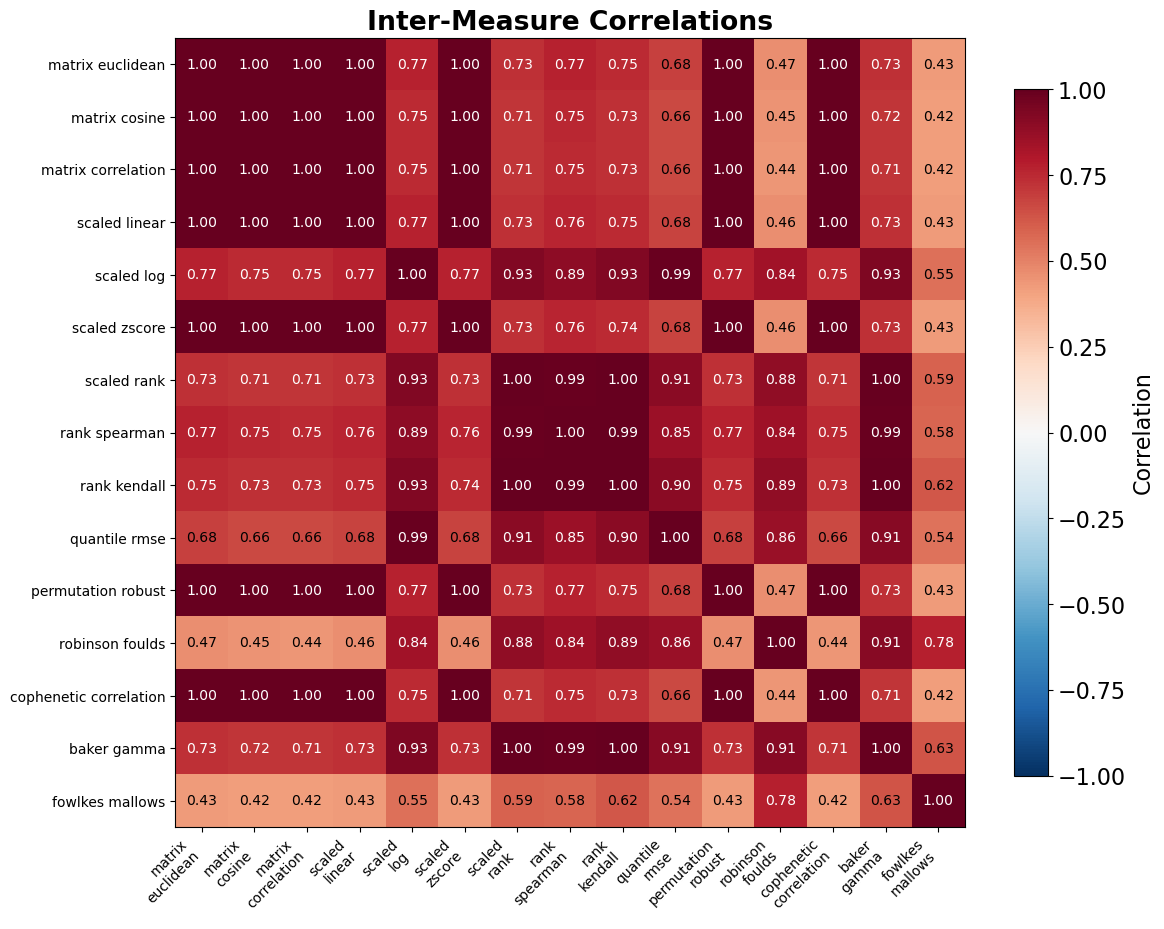

✓ Comprehensive distance-of-distances analysis completed!


In [25]:
# SUMMARY STATISTICS AND CORRELATIONS BETWEEN MEASURES

print("=== SUMMARY STATISTICS ===")
print(f"Analysis for Patient: {patient}, Band: {band}")
print(f"Number of measures analyzed: {len(all_measures)}")
print(f"Phases compared: {phase_labels}")
print()

# Calculate summary statistics for each measure
summary_stats = {}
for measure_name, distance_matrix in all_measures.items():
    # Get upper triangular values (exclude diagonal)
    triu_vals = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
    summary_stats[measure_name] = {
        'mean': np.mean(triu_vals),
        'std': np.std(triu_vals),
        'min': np.min(triu_vals),
        'max': np.max(triu_vals),
        'range': np.max(triu_vals) - np.min(triu_vals)
    }

# Display summary table
print("Measure Name                    Mean      Std       Min       Max       Range")
print("-" * 80)
for measure_name, stats in summary_stats.items():
    print(f"{measure_name:30s} {stats['mean']:8.4f}  {stats['std']:8.4f}  {stats['min']:8.4f}  {stats['max']:8.4f}  {stats['range']:8.4f}")

print("\n=== INTER-MEASURE CORRELATIONS ===")
# Compute correlations between different measures
measure_names = list(all_measures.keys())
n_measures = len(measure_names)
correlation_matrix = np.zeros((n_measures, n_measures))

for i, measure1 in enumerate(measure_names):
    for j, measure2 in enumerate(measure_names):
        if i == j:
            correlation_matrix[i, j] = 1.0
        else:
            # Get upper triangular values for both measures
            vals1 = all_measures[measure1][np.triu_indices_from(all_measures[measure1], k=1)]
            vals2 = all_measures[measure2][np.triu_indices_from(all_measures[measure2], k=1)]
            correlation_matrix[i, j] = np.corrcoef(vals1, vals2)[0, 1]

# Visualize inter-measure correlations
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xticks(range(n_measures))
ax.set_yticks(range(n_measures))
ax.set_xticklabels([name.replace('_', '\n') for name in measure_names], rotation=45, ha='right')
ax.set_yticklabels([name.replace('_', ' ') for name in measure_names], )
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_title('Inter-Measure Correlations', fontweight='bold')

# Add correlation values to the plot
for i in range(n_measures):
    for j in range(n_measures):
        text = ax.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                      ha="center", va="center", color="black" if abs(correlation_matrix[i, j]) < 0.7 else "white",
                      fontsize=10)

plt.colorbar(im, ax=ax, shrink=0.8, label='Correlation')
plt.tight_layout()
plt.savefig(path_figs / f'inter_measure_correlations_{patient}_{band}.pdf', bbox_inches='tight', transparent=True)
plt.show()

print("✓ Comprehensive distance-of-distances analysis completed!")

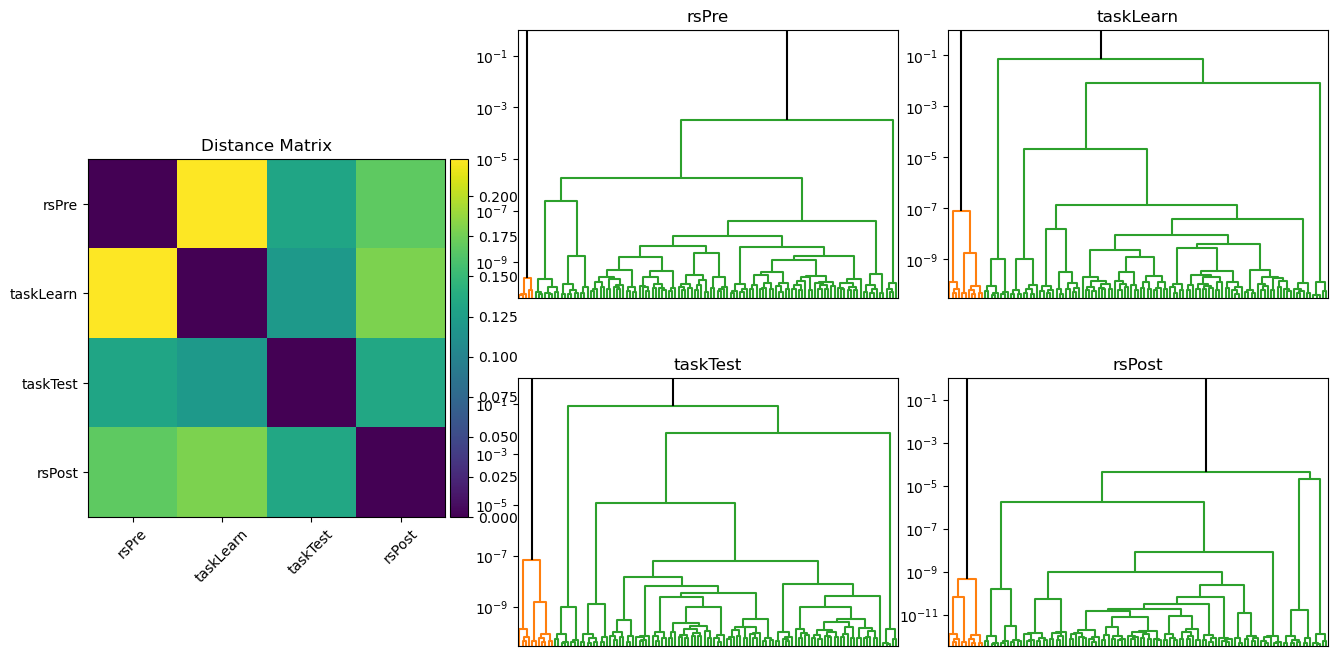

In [17]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, optimal_leaf_ordering

# Create figure with GridSpec for custom layout
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 6, figure=fig, hspace=0.3, wspace=0.3)

# Left subplot for distance matrix - now spans 2 columns instead of 1
ax_dist = fig.add_subplot(gs[:, 0:2])
im = ax_dist.imshow(distance_matrix, cmap='viridis')
ax_dist.set_title('Distance Matrix')
ax_dist.set_xticks(range(len(phase_labels)))
ax_dist.set_yticks(range(len(phase_labels)))
ax_dist.set_xticklabels(phase_labels, rotation=45)
ax_dist.set_yticklabels(phase_labels)
div, cax, clb = imshow_colorbar_caxdivider(im, ax_dist)
# plt.colorbar(im, ax=ax_dist)

# Right subplots for dendrograms (2x2 grid) - now starting from column 2
for i, phase in enumerate(phase_labels):
    row = i // 2
    col = i % 2 + 2  # Start from column 2 (after distance matrix)
    if col == 2:
        ax_dend = fig.add_subplot(gs[row, 2:4])  # Span 2 columns for first dendrogram in each row
    else:
        ax_dend = fig.add_subplot(gs[row, 4:6])  # Span 2 columns for second dendrogram in each row
    
    lnkg = linkage_matrices[phase][band]
    Z_opt = optimal_leaf_ordering(lnkg, cond_dist_matrices[phase][band])
    dendrogram(Z_opt, ax=ax_dend, no_labels=True, **kw_dentro)
    ax_dend.set_yscale('log')
    tmin = lnkg[:, 2][0] * 0.8
    tmax = lnkg[:, 2][-1] * 1.01
    ax_dend.set_ylim(tmin, tmax)
    ax_dend.set_title(f'{phase}')

plt.show()

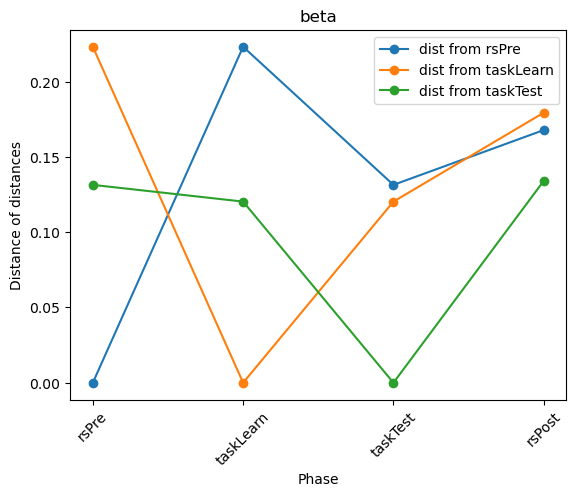

In [18]:
plt.plot(np.arange(4), distance_matrix[0], 'o-', label='dist from rsPre')
plt.plot(np.arange(4), distance_matrix[1], 'o-', label='dist from taskLearn')
plt.plot(np.arange(4), distance_matrix[2], 'o-', label='dist from taskTest')

plt.title(band)
plt.ylabel('Distance of distances')
plt.xlabel('Phase')
plt.legend()
plt.xticks(np.arange(4), phase_labels, rotation=45)
plt.savefig(path_figs / f'distance_of_distances_{patient}_{band}.png', bbox_inches='tight')
# plt.plot(np.arange(4), distance_matrix[2], 'o')